## INITIALIZE: load trial info

In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [2]:
with open("C:/Users/Sarah Zheng/dev/cards-deception/cards-game/src/assets/trials_40shuffled.json", "r") as read_file:
    trials_source = json.load(read_file)

In [3]:
trials = pd.DataFrame(trials_source)

In [4]:
# add expectation violation levels
trials['exp_violation'] = np.where(trials['outcome'] == -1, trials['outcome'] - trials['outcome'] * (trials['n_red']/5), \
                                   trials['outcome'] - trials['outcome'] * (5-trials['n_red'])/5)

In [5]:
trials.head()

n_red  outcome  exp_violation
0      1       -1           -0.8
1      3       -1           -0.4
2      2        1            0.4
3      1       -1           -0.8
4      2       -1           -0.6

[Text(0.5, 0, 'trial'), Text(0, 0.5, 'expectation violation at each trial')]

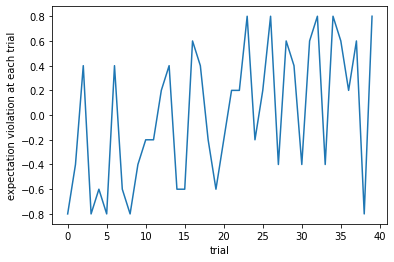

In [17]:
sns.lineplot(data=trials.exp_violation, legend=False).set(xlabel="trial", ylabel="expectation violation at each trial")

In [8]:
# trial-to-trial change in expectation violation
exp_violation_gradient = trials.exp_violation.diff()

[Text(0.5, 0, 'trial'), Text(0, 0.5, 'change in expectation violation')]

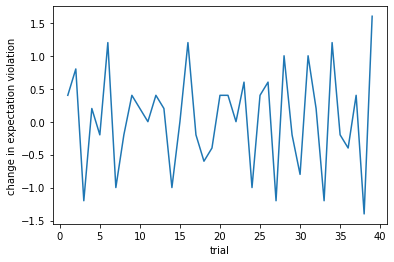

In [9]:
sns.lineplot(data=exp_violation_gradient, legend=False).set(xlabel="trial", ylabel="change in expectation violation")

In [10]:
trials.exp_violation.cumsum().head()

0   -0.8
1   -1.2
2   -0.8
3   -1.6
4   -2.2
Name: exp_violation, dtype: float64

[Text(0.5, 0, 'trial'),
 Text(0, 0.5, 'cumulative range in expectation violation')]

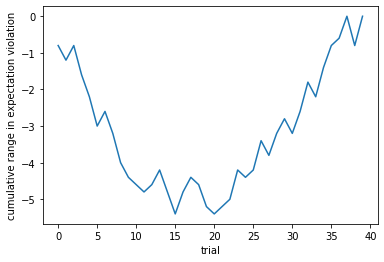

In [11]:
# cumulative sum of expectation violation over trials
sns.lineplot(data=trials.exp_violation.cumsum(), legend=False).set(xlabel="trial", ylabel="cumulative range in expectation violation")

In [12]:
exp_violation_gradient.max()

1.6

In [12]:
exp_violation_gradient.mean()

0.041025641025641026

In [13]:
exp_violation_gradient.std()

0.7652718638765087

In [6]:
# masks for each level of expectation violation
mask_min08 = trials[trials.exp_violation == '-0.8'].index.tolist()
mask_min06 = trials[trials.exp_violation == '-0.6'].index.tolist()
mask_min04 = trials[trials.exp_violation == '-0.4'].index.tolist()
mask_min02 = trials[trials.exp_violation == '-0.2'].index.tolist()

mask_08 = trials[trials.exp_violation == '0.8'].index.tolist()
mask_06 = trials[trials.exp_violation == '0.6'].index.tolist()
mask_04 = trials[trials.exp_violation == '0.4'].index.tolist()
mask_02 = trials[trials.exp_violation == '0.2'].index.tolist()

masks = [mask_min08, mask_min06, mask_min04, mask_min02, mask_02, mask_04, mask_06, mask_08]

In [7]:
# get indexes of trials by # red cards = states
idx_n_red = []

for i in set(trials.n_red):
    idxs = trials[trials.n_red == i].index.tolist()
    print("#red cards:", i, "at", idxs)
    idx_n_red.append(idxs)

#red cards: 1 at [0, 3, 5, 8, 12, 21, 22, 25, 36, 38]
#red cards: 2 at [2, 4, 6, 7, 13, 14, 15, 17, 19, 29]
#red cards: 3 at [1, 9, 16, 27, 28, 30, 31, 33, 35, 37]
#red cards: 4 at [10, 11, 18, 20, 23, 24, 26, 32, 34, 39]


## get pilot data

In [8]:
# pilot uuids
uuids = ['5fe200ac3803bbcff9845530', 
         '5ff5c230bce45b062a2a06b2', 
         '5f1b05a8703c380d1393bb27', 
         '5b424267e8815c0001777d94', 
         '604294f7bacd9a1a46cf4da5']

In [9]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

# Use a service account
cred = credentials.Certificate('D:/Behavioural cybersecurity/project-notes/cards-dd-game-61b9b7f26a6e.json')
firebase_admin.initialize_app(cred)

db = firestore.client()

subjects_ref = db.collection(u'subjects')

In [10]:
# responses query reference
refs = []
for uuid in uuids:
    refs.append(subjects_ref.document(uuid).collection(u'responses').document('main_responses').get())

In [13]:
# demographics survey query reference
refs_demographics = []
for uuid in uuids:
    refs_demographics.append(subjects_ref.document(uuid).collection(u'responses').document('demographics').get())

In [14]:
# card values
transdict = {'blue': 1, 'red': -1}

In [15]:
# result values
results_transdict = {'tie': 0.5, 'loss': 1, 'win': 0}

## Fetch responses from DB

In [16]:
class GameResponses(object):
    def __init__(self, randomPick, randomPickColour, reportColour, RTreport, honestyRating, RThonesty,
                 results, catchRating, RTcatch):
        self.randomPick = randomPick
        self.randomPickColour = randomPickColour
        self.reportColour = reportColour
        self.honestyRating = honestyRating
        self.catchRating = catchRating
        self.RThonesty = RThonesty
        self.RTreport = RTreport
        self.RTcatch = RTcatch
        self.results = results

    @staticmethod
    def from_dict(source):
        gresponse = GameResponses(source[u'randomPick'], source[u'randomPickColour'], source[u'reportColour'],
                                  source[u'RTreport'], source[u'honestyRating'], source[u'RThonesty'], 
                                  source[u'results'], source[u'catchRating'], source[u'RTcatch'])

        return gresponse

    def to_dict(self):
        dest = {
            u'randomPick': self.randomPick,
            u'randomPickColour': self.randomPickColour,
            u'reportColour': self.reportColour,
            u'RTreport': self.RTreport,
            u'honestyRating': self.honestyRating,
            u'RThonesty': self.RThonesty,
            u'results': self.results,
            u'catchRating': self.catchRating,
            u'RTcatch': self.catch
        }

        return dest

In [17]:
class Demographics(object):
    def __init__(self, age, catch, edlev, gender, twin):
        self.age = age
        self.catch = catch
        self.edlev = edlev
        self.gender = gender
        self.twin = twin

    @staticmethod
    def from_dict(source):
        demos = Demographics(source[u'age'], source[u'catch'], source[u'edlev'],
                                  source[u'gender'], source[u'twin'])

        return demos

    def to_dict(self):
        dest = {
            u'age': self.age,
            u'catch': self.catch,
            u'edlev': self.edlev,
            u'gender': self.gender,
            u'twin': self.twin
        }

        return dest

In [18]:
# main game response data
honestyRatings = []
catchRating = []
reportHonesty = []
gameResults = []
transGameResults = []
RThonesty = []
RTreport = []

randomPickColour = []
reportColour = []

for index, subject in enumerate(refs):
    responses = GameResponses.from_dict(subject.to_dict())
    
    ratings = [int(numeric_string) for numeric_string in responses.honestyRating]
    honestyRatings.append(ratings)
    
    catch = [int(numeric_string) for numeric_string in responses.catchRating]
    catchRating.append(catch)
    
    ifLied = np.array([transdict[x] for x in responses.randomPickColour]) == responses.reportColour
    reportHonesty.append(ifLied)
    
    gameResults.append(responses.results)
    
    transResults = np.array([results_transdict[x] for x in responses.results]) 
    transGameResults.append(transResults)
    
    RThonesty.append(responses.RThonesty)
    RTreport.append(responses.RTreport)
    
    randomPickColour.append([x for x in responses.randomPickColour])
    reportColour.append([x for x in responses.reportColour])

### visualise game progressions

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

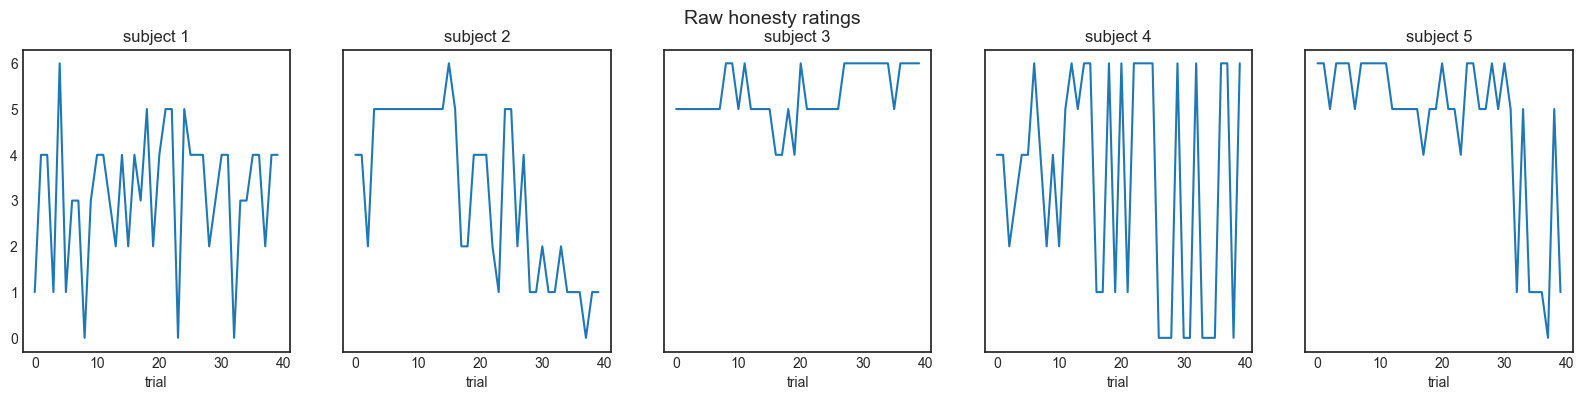

In [20]:
fig, axs = plt.subplots(1, 5, sharey='all', figsize=(20,4), dpi=100)
fig.suptitle('Raw honesty ratings', fontsize=14)

for i in range(5):
    axs[i].plot(range(len(trials)), honestyRatings[i])
    axs[i].set_xlabel('trial')
    axs[i].set_title('subject '+str(i+1))

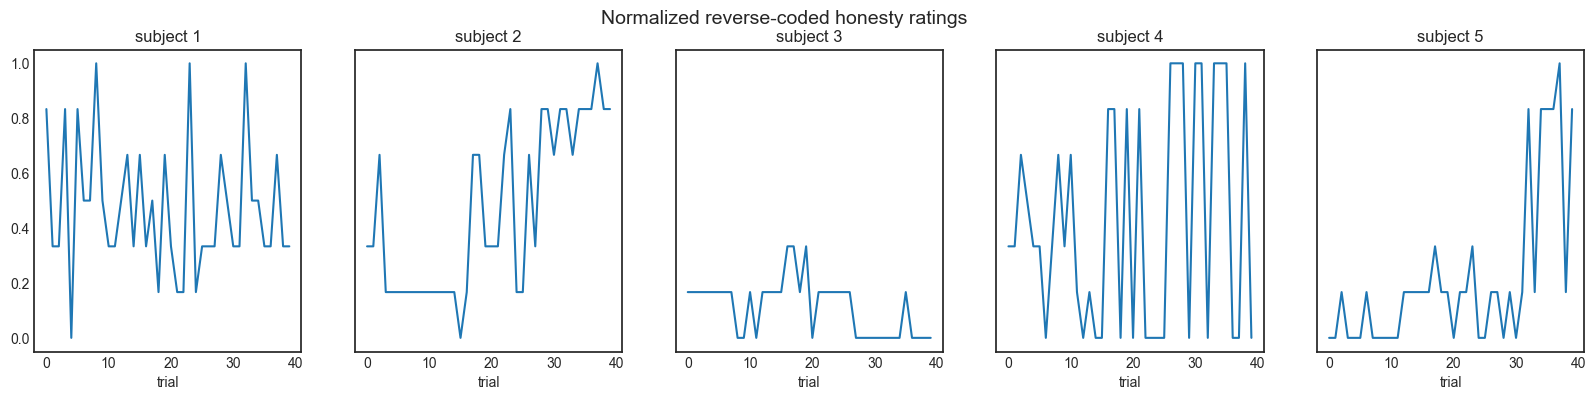

In [40]:
fig, axs = plt.subplots(1, 5, sharey='all', figsize=(20,4), dpi=100)
fig.suptitle('Normalized reverse-coded honesty ratings', fontsize=14)

for i in range(5):
    axs[i].plot(range(len(trials)), normalized_suspicion_ratings[i])
    axs[i].set_xlabel('trial')
    axs[i].set_title('subject '+str(i+1))

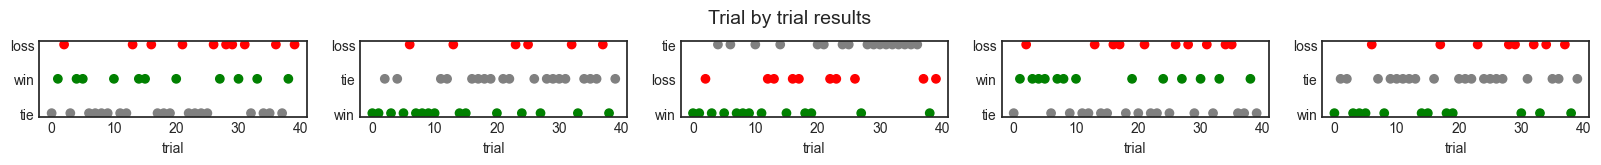

In [36]:
fig, axs = plt.subplots(1, 5, sharey='col', figsize=(20,1), dpi=100)
fig.suptitle('Trial by trial results', fontsize=14, y=1.2)
colors = {"loss": 'red', "tie": "gray", "win": "green"}
    
for i in range(5):
    axs[i].scatter(x=range(len(trials)), y=gameResults[i], c=pd.Series(gameResults[i]).apply(lambda x: colors[x]))
    axs[i].set_xlabel('trial')
#     axs[i].set_title('subject '+str(i+1))

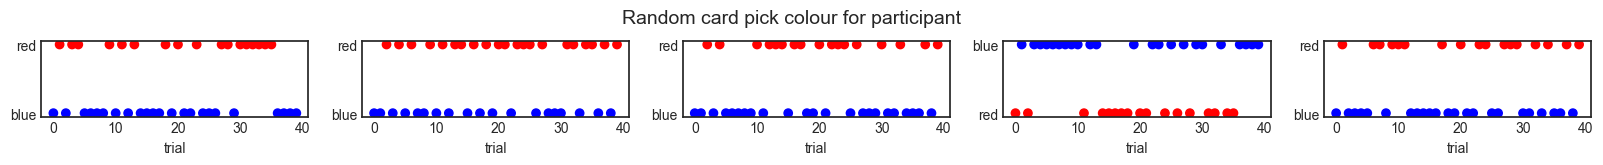

In [37]:
fig, axs = plt.subplots(1, 5, sharey='col', figsize=(20,1), dpi=100)
fig.suptitle('Random card pick colour for participant', fontsize=14, y=1.2)
colors = {"red": "red", "blue": "blue"}

for i in range(5):
    axs[i].scatter(range(len(trials)), randomPickColour[i], c=pd.Series(randomPickColour[i]).apply(lambda x: colors[x]))
    axs[i].set_xlabel('trial')
#     axs[i].set_title('subject '+str(i+1))

## save specific subject data to .csv file

In [75]:
i=3

dict_subject = {
    "trial": range(1,41),
    "n_red": trials.n_red,
    "n_blue": 5-trials.n_red,
    "opponent_report": trials.outcome,
    "expectation_violation": trials.exp_violation,
#     "suspicion_perfect_alpha": tmp,
#     "normalized_estimated_suspicion_rating": tmp2,
    "random_pick_colour": [transdict[x] for x in randomPickColour[i]],
    "reported_pick_colour": reportColour[i],
    "honest_card_report": reportHonesty[i],
    "trial_result": transGameResults[i],
    "honesty_rating": honestyRatings[i],
    "RT_honesty": RThonesty[i],
    "normalized_reversed_honesty_rating": normalized_suspicion_ratings[i]
}

In [76]:
df_subject = pd.DataFrame(dict_subject)

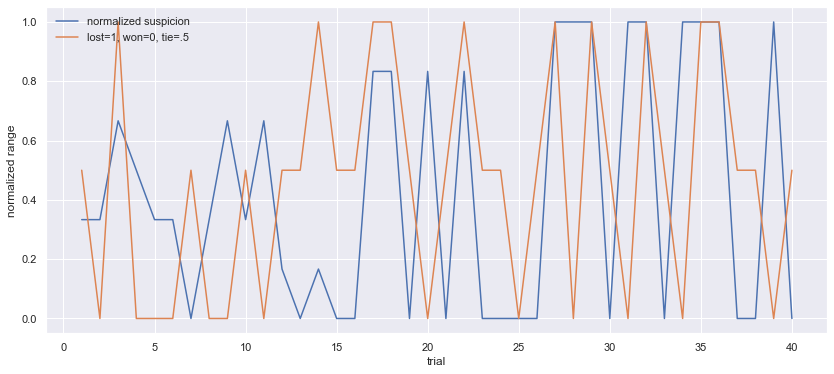

In [77]:
report_red = df_subject[df_subject.reported_pick_colour == -1]

sns.lineplot(data=df_subject, x='trial', y='normalized_reversed_honesty_rating')
sns.lineplot(data=df_subject, x='trial', y='trial_result')
sns.set(rc={'figure.figsize':(14,6)})
plt.xlabel("trial")
plt.ylabel("normalized range")
plt.legend(labels=['normalized suspicion', 'lost=1, won=0, tie=.5'])

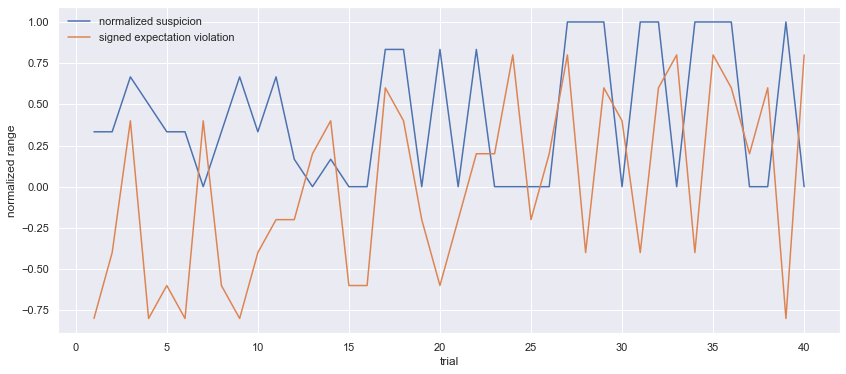

In [78]:
sns.lineplot(data=df_subject, x='trial', y='normalized_reversed_honesty_rating')
sns.lineplot(data=df_subject, x='trial', y='expectation_violation')
sns.set(rc={'figure.figsize':(14,6)})
plt.xlabel("trial")
plt.ylabel("normalized range")
plt.legend(labels=['normalized suspicion', 'signed expectation violation'])

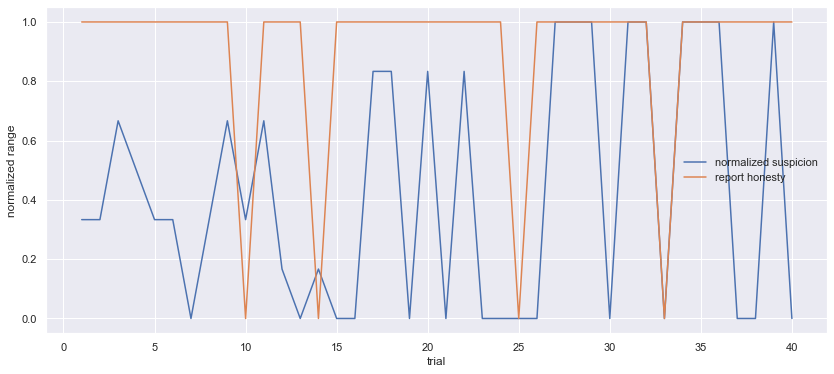

In [79]:
sns.lineplot(data=df_subject, x='trial', y='normalized_reversed_honesty_rating')
sns.lineplot(data=df_subject, x='trial', y='honest_card_report')
sns.set(rc={'figure.figsize':(14,6)})
plt.xlabel("trial")
plt.ylabel("normalized range")
plt.legend(labels=['normalized suspicion', 'report honesty'])

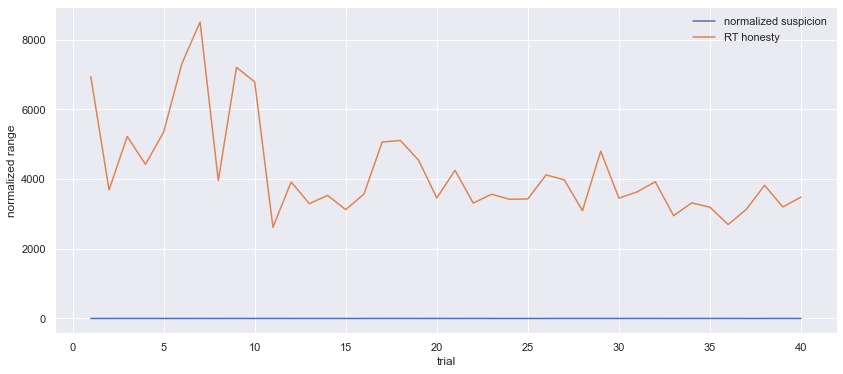

In [80]:
sns.lineplot(data=df_subject, x='trial', y='normalized_reversed_honesty_rating')
sns.lineplot(data=df_subject, x='trial', y='RT_honesty')
sns.set(rc={'figure.figsize':(14,6)})
plt.xlabel("trial")
plt.ylabel("normalized range")
plt.legend(labels=['normalized suspicion', 'RT honesty'])

In [ ]:
# what player reports
# colour of card pick

# what colour the opponent reports

In [310]:
df_subject.to_csv('pilot_subject1.csv', encoding='utf-8')

In [100]:
# export honesty ratings to .csv file
import csv
with open('pilot_honestyratings.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerows(honestyRatings)

### [CONTROL] attention check questions

In [25]:
# demographics data
edlev = []
catch = []

for subject in refs_demographics:
    demos = Demographics.from_dict(subject.to_dict())
    edlev.append(demos.edlev)
    catch.append(demos.catch)

In [26]:
catch

[2, 2, 2, 2, 2]

In [27]:
# in-game attention checks
catchRating

[[3, 5, 4, 2, 0, 3, 0],
 [3, 5, 4, 2, 0, 3, 0],
 [3, 5, 4, 2, 0, 3, 0],
 [3, 5, 4, 2, 0, 3, 0],
 [3, 5, 4, 2, 0, 3, 0]]

### RT honesty ratings

In [22]:
RThonesty_stats = pd.DataFrame(columns=['mean', 'sd', 'min', 'max'])

for id in RThonesty:
    mean = sum(id)/len(id)
    sd = np.array(id).std()
    vmin = min(id)
    vmax = max(id)
    tmp = {'mean': mean, 'sd': sd, 'min': vmin, 'max': vmax}
    print(tmp)
    RThonesty_stats.append(tmp, ignore_index=True)

{'mean': 2538.031875001616, 'sd': 1287.7030834535024, 'min': 1151.639999996405, 'max': 7963.415000005625}
{'mean': 46645.97524998244, 'sd': 241618.01439988153, 'min': 1153.0949999578297, 'max': 1551737.1999998577}
{'mean': 3165.975, 'sd': 680.7276800417329, 'min': 1801, 'max': 4373}
{'mean': 4211.902500001452, 'sd': 1372.3167816641028, 'min': 2619.6000000054482, 'max': 8512.599999987287}
{'mean': 2318.0392500013113, 'sd': 847.1408916995828, 'min': 1216.4600000251085, 'max': 4496.710000094026}


## Preprocessing honesty ratings -> suspicion ratings

### [honesty rating] normalize honesty ratings to range [0;1] and reverse-code

In [23]:
normalized_honesty_ratings = []

for ratings in honestyRatings:
    normed = [(v/6) for v in ratings]
    normalized_honesty_ratings.append(normed)

In [24]:
# reverse-code honesty ratings to reflect suspicion
import numexpr
suspicionRating = numexpr.evaluate('(6 - honestyRatings)')

In [25]:
normalized_suspicion_ratings = numexpr.evaluate('(1 - normalized_honesty_ratings)')

In [26]:
normalized_suspicion_ratings

array([[0.83333333, 0.33333333, 0.33333333, 0.83333333, 0.        ,
        0.83333333, 0.5       , 0.5       , 1.        , 0.5       ,
        0.33333333, 0.33333333, 0.5       , 0.66666667, 0.33333333,
        0.66666667, 0.33333333, 0.5       , 0.16666667, 0.66666667,
        0.33333333, 0.16666667, 0.16666667, 1.        , 0.16666667,
        0.33333333, 0.33333333, 0.33333333, 0.66666667, 0.5       ,
        0.33333333, 0.33333333, 1.        , 0.5       , 0.5       ,
        0.33333333, 0.33333333, 0.66666667, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.66666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.        , 0.16666667, 0.66666667, 0.66666667, 0.33333333,
        0.33333333, 0.33333333, 0.66666667, 0.83333333, 0.16666667,
        0.16666667, 0.66666667, 0.33333333, 0.83333333, 0.83333333,
        0.66666667, 0.83333333, 0.83333333, 0.6

### [honesty rating] binarize reversed-coded honesty ratings

In [27]:
binary_suspicion_ratings = []

for ratings in suspicionRating:
    binary = [1 if v >= 4 else 0 for v in ratings]
    binary_suspicion_ratings.append(binary)

In [28]:
binary_suspicion_ratings[1][0:5]

[0, 0, 1, 0, 0]

### [honesty rating] z-scored raw reverse-coded honesty ratings

In [29]:
# APPROACH 1: get pooled mean and SD stats from all participants
bin_mean_HRs = []
bin_sd_HRs = []

for rating in suspicionRating:
    bin_mean_HRs.append(sum(rating)/len(rating))
    bin_sd_HRs.append(np.array(rating).std())

In [30]:
z_mean_HRs = np.array(bin_mean_HRs).mean()
z_sd_HRs = np.array(bin_mean_HRs).std()

In [31]:
# z-scored suspicion ratings compared cross-participants
z_suspicion_ratings = []

for rating in suspicionRating:
    z_rating = [(x-z_mean_HRs)/z_sd_HRs for x in rating]
    z_suspicion_ratings.append(z_rating)

In [32]:
z_sd_HRs

0.8778382538941898

In [ ]:
# APPROACH 2: z-score each participant's ratings -> takes away inter-subject variance comparison

### [honesty rating] log transform normalized reverse-coded honesty ratings

In [33]:
tmp_log_suspicionrating = [np.log(v+1) for v in normalized_suspicion_ratings[4]]

[Text(0.5, 0, 'trial'), Text(0, 0.5, 'log normalized honesty rating')]

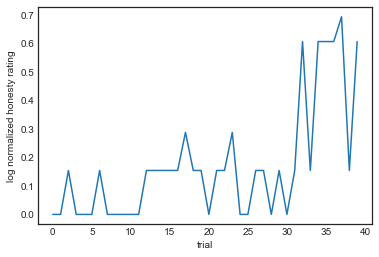

In [34]:
sns.lineplot(data=tmp_log_suspicionrating, legend=False).set(xlabel="trial", ylabel="log normalized honesty rating")

## Initial inspection plots

### plot honesty ratings

In [ ]:
for i in range(len(honestyRatings)):
    sns.lineplot(data=honestyRatings[i], legend=False).set(xlabel="trial", ylabel="honesty rating")

In [ ]:
for i in range(len(honestyRatings)):
    sns.lineplot(data=normalized_suspicion_ratings[i], legend=False).set(xlabel="trial", ylabel="suspicion rating (reversed honesty)")

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=gameResults[0], legend=False).set(xlabel="trial", ylabel="game result")

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=trials.exp_violation, legend=False).set(xlabel="trial", ylabel="expectation violation")

In [ ]:
ev_tmp = exp_violation_gradient.cumsum().fillna(0)

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=ev_tmp, legend=False).set(xlabel="trial", ylabel="cumulative expectation violation")

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=exp_violation_gradient, legend=False).set(xlabel="trial", ylabel="change in expectation violation")

In [ ]:
# subject that lied least
sns.lineplot(data=honestyRatings[2], legend=True)
sns.lineplot(data=gameResults[2], legend=True).set(xlabel="trial", ylabel="game result")

## Model fits

### parameter estimation - grid search

In [41]:
from specs import *

from itertools import product

In [49]:
# parameter search space
alpha = np.linspace(0.1,1,10)
beta = np.linspace(-10,20,31)
params = tuple(product(alpha, beta))

trials = []
for trial in trials_source:
    trials.append(Trial(n_red=trial['n_red'], outcome=trial['outcome']))

x0 = [0.2, 1] # starting point (guess)

In [73]:
alpha

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [102]:
set(normalized_suspicion_ratings[0])

{0.0,
 0.16666666666666663,
 0.33333333333333337,
 0.5,
 0.6666666666666667,
 0.8333333333333334,
 1.0}

### [model 1] using suspicion formula with normalized scale

In [103]:
from analysis import *

In [126]:
import inspect
lines = inspect.getsource(normalize)
print(lines)

def normalize(x):
    return x/5.4  # NOTE: this is based on game trials order with Player alpha=1



In [127]:
def normalize(x):
    return x/5.4

def normalized_array(array):
    tmp = [x+abs(min(array)) for x in array] # NOTE: this is based on game trials order with Player alpha=1
    return [normalize(x) for x in tmp]

In [118]:
def param_estim_norm_sv(x, alpha):
    x = np.array(x)
    SSres = []
    for a in alpha:
        player = Player(alpha=a)
        g = Game(trials, player)
        g.simulate(verbose=False)
        sv = np.array(g.suspicion_values)
        normed_sv = normalized_array(sv)
        SSres.append(sum((x-normed_sv)**2))
    minimum_idx = np.where(SSres == np.amin(SSres))[0]
    print("SSresiduals for each params search space value:", SSres)
    print("SSresiduals minimum index:", minimum_idx)
    for idx in minimum_idx:
        print("BEST ALPHA ESTIMATE:", alpha[idx])
    return np.array(SSres), minimum_idx, alpha[minimum_idx[0]]

In [129]:
def df_best_norm_sv(x, alphas):
    x = np.array(x)
    SSres, best_alpha_idx, best_alpha = param_estim_norm_sv(x, alphas)
    SStot = sum([(v-x.mean())**2 for v in x])
    R2 = 1-SSres[best_alpha_idx]/SStot

    best_sim = Game(trials, Player(alpha=best_alpha))
    best_sim.simulate(verbose=False)
    best_estimated_sv = best_sim.suspicion_values
    normed_sv = normalized_array(best_estimated_sv)
        
    df = pd.DataFrame({'value': normed_sv, 'label': ['estimated'] * len(normed_sv)})
    df = df.append(pd.DataFrame({'value': x, 'label': ['actual'] * len(x)}), ignore_index=False)
    
    print("normalized suspicion values w/best model params", normed_sv)
    print("best fit alpha value", best_alpha)
    print("SSres", SSres[best_alpha_idx])
    print("SStot", SStot)
    print("R squared:", R2)
    return df

In [175]:
df = df_best_norm_sv(normalized_suspicion_ratings[4], alpha)

starting game play simulation
player attributes: bias:  0 alpha:  0.1 beta: 0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of t

normalized suspicion values w/best model params [0.4259259259259259, 0.3888888888888888, 0.4259259259259259, 0.35185185185185175, 0.2962962962962962, 0.22222222222222215, 0.2592592592592592, 0.20370370370370364, 0.12962962962962957, 0.0925925925925925, 0.07407407407407397, 0.055555555555555435, 0.07407407407407397, 0.11111111111111104, 0.05555555555555552, 0.0, 0.05555555555555552, 0.09259259259259259, 0.07407407407407406, 0.018518518518518535, 0.0, 0.018518518518518535, 0.03703703703703707, 0.11111111111111112, 0.09259259259259259, 0.11111111111111112, 0.18518518518518517, 0.14814814814814814, 0.20370370370370372, 0.24074074074074073, 0.20370370370370372, 0.25925925925925924, 0.33333333333333337, 0.2962962962962963, 0.37037037037037035, 0.42592592592592593, 0.4444444444444444, 0.5, 0.4259259259259259, 0.5]
best fit alpha value 0.5
SSres [2.33093278]
SStot 3.2888888888888883
R squared: [0.29127044]


In [176]:
g = Game(trials, Player(alpha=0.5))

In [177]:
g.simulate()

starting game play simulation
player attributes: bias:  0 alpha:  0.5 beta: 0
trial:  1
suspicion_t: 0
# red cards:  1
randomly picked card for player:  1
opponent card: red
You win 1 point
You lose 1 point
change in suspicion:  0.4
new player suspicion:  -0.4 

number of trials with given n_red: 1
probability of suspicion rating:  1.0
trial:  2
suspicion_t: -0.4
# red cards:  3
randomly picked card for player:  -1
opponent card: red
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
change in suspicion:  0.20000000000000007
new player suspicion:  -0.6000000000000001 

number of trials with given n_red: 1
probability of suspicion rating:  1.0
trial:  3
suspicion_t: -0.6000000000000001
# red cards:  2
randomly picked card for player:  1
opponent card: blue
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
change in suspicion:  0.2
new player suspicion:  -0.4000000000000001 

number of trials with given n_red: 1
probability o

In [178]:
g.suspicion_values

[-0.4,
 -0.6000000000000001,
 -0.4000000000000001,
 -0.8,
 -1.1,
 -1.5,
 -1.3,
 -1.6,
 -2.0,
 -2.2,
 -2.3000000000000003,
 -2.4000000000000004,
 -2.3000000000000003,
 -2.1,
 -2.4,
 -2.6999999999999997,
 -2.4,
 -2.1999999999999997,
 -2.3,
 -2.5999999999999996,
 -2.6999999999999997,
 -2.5999999999999996,
 -2.4999999999999996,
 -2.0999999999999996,
 -2.1999999999999997,
 -2.0999999999999996,
 -1.6999999999999997,
 -1.8999999999999997,
 -1.5999999999999996,
 -1.3999999999999997,
 -1.5999999999999996,
 -1.2999999999999996,
 -0.8999999999999996,
 -1.0999999999999996,
 -0.6999999999999996,
 -0.39999999999999963,
 -0.29999999999999966,
 3.3306690738754696e-16,
 -0.3999999999999997,
 3.3306690738754696e-16]

In [179]:
tmp = normalized_array(g.suspicion_values)

[Text(0.5, 0, 'trial'), Text(0, 0.5, 'normalized suspicion'), (0.0, 1.1)]

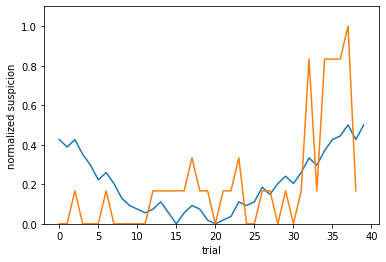

In [180]:
sns.lineplot(data=normalized_array(g.suspicion_values))
sns.lineplot(data=df.value[40:79]).set(xlabel="trial", ylabel="normalized suspicion", ylim=(0,1.1))

### [model 3] using softmax probability

In [50]:
def param_recovery_proba(x, params):
    '''returns sum of squared residuals for each fitted parameter value combination, and best parameter values index'''
    SSres = []
    for param in params:
        player = Player(alpha=param[0], beta=param[1])
        g = Game(trials, player)
        g.simulate(verbose=False)
        ps = np.array(g.softmax_probabilities)
        SSres.append(sum((x-ps)**2))
    minimum_idx = np.where(SSres == np.amin(SSres))[0]
    print("SSresiduals minimum index:", minimum_idx)
    for idx in minimum_idx:
        print("BEST PARAMETER ESTIMATES:", params[idx])
    return np.array(SSres), minimum_idx

In [53]:
def df_best_estimations(x, params):
    '''generates long dataframe with estimated and actual data'''
    x = np.array(x)
    SSres, best_params_idx = param_recovery_proba(x, params)
    SStot = sum([(v-x.mean())**2 for v in x])
    R2 = 1-SSres[best_params_idx]/SStot
    
    best_sim = Game(trials, Player(alpha=params[best_params_idx[0]][0], beta=params[best_params_idx[0]][1]))
    best_sim.simulate(verbose=False)
    best_estimated_proba = best_sim.softmax_probabilities
    
    df = pd.DataFrame({'value': best_estimated_proba, 'label': ['estimated'] * len(best_estimated_proba)})
    df = df.append(pd.DataFrame({'value': x, 'label': ['actual'] * len(x)}), ignore_index=False)
    print("SSres", SSres[best_params_idx])
    print("SStot", SStot)
    print("R squared:", R2)
    return df

starting game play simulation
player attributes: bias:  0 alpha:  0.1 beta: -10.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number 

trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  21
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  22
You lose 1 point
You win 1 point
number of trials with given n_red: 6
trial:  23
It's a tie: nob

trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a

trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.2 beta: -6.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
tri

trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses

trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  24
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of tria

trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
You win 1 point
You lose 1 point
number of trials with given n_red: 8
trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  39
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  40
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.30000000000000004 beta: -2.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses

trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of tria

number of trials with given n_red: 2
trial:  11
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  12
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 

number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  13
You lose 1 point
You win 1 point
number of trials w

number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wi

number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
You win 1 point
You lose 1 point
number of trials with given n_red: 8
trial:  35
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with giv

number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or 

trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
You win 1 point
You lose 1 point

trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of tria

You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  27
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of

number of trials with given n_red: 2
trial:  11
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:

trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
You win 1 point
You lose 1 point
number of trials with given n_red: 8
trial:  35
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  36
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.7000000000000001 beta: -1.0
trial:  1
It's a tie: nobody wins or loses a point
I

trial:  36
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.7000000000000001 beta: 11.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point

You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.8 beta: -10.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a

You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobod

trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or l

trial:  9
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobo

trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of tria

number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a

You lose 1 point
number of trials with given n_red: 3
trial:  20
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  26
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
You lose 1

You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  30
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 

number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
You lose 1 point
You win 1 point
number of trials with giv

[Text(0.5, 0, 'trial'), Text(0, 0.5, 'p(deception)')]

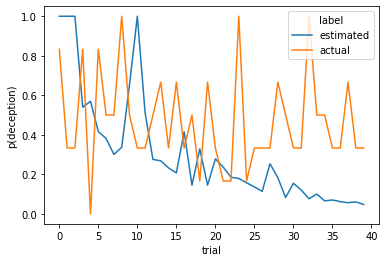

In [62]:
df = df_best_estimations(normalized_suspicion_ratings[0], params)
sns.lineplot(data=df, x=df.index, y='value', hue='label').set(xlabel="trial", ylabel="p(deception)")

starting game play simulation
player attributes: bias:  0 alpha:  0.1 beta: -10.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
tr

You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials w

trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.1 beta: 14.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
I

trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  39
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.2 beta: -6.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of 

number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  24
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
You lose 1

trial:  34
You win 1 point
You lose 1 point
number of trials with given n_red: 8
trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.2 beta: 19.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point


end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.30000000000000004 beta: 1.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
It's a tie: nobody wins or loses a p

number of trials with given n_red: 7
trial:  24
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  31
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  32
It's a tie: nobody wins or loses a point
It's a tie: nobod

trial:  8
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials

trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.4 beta: 6.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 poin

number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or l

number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alph

number of trials with given n_red: 9
trial:  36
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.5 beta: 12.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
numb

trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
It's a tie: nobod

It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody

end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.6 beta: 17.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You

You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's 

end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.7000000000000001 beta: 11.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: 

trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_

number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.8 beta: 5.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with give

You lose 1 point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red:

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  1

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
You lose 

number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of

It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red

You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
You lose 1 point
You win 1 point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a

[Text(0.5, 0, 'trial win/loss/tie'), Text(0, 0.5, 'p(deception)')]

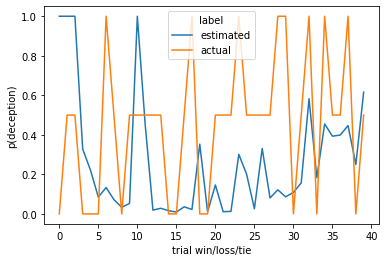

In [92]:
df = df_best_estimations(transGameResults[4], params)
sns.lineplot(data=df, x=df.index, y='value', hue='label').set(xlabel="trial win/loss/tie", ylabel="p(deception)")

## aggregated analyses across participants

In [ ]:
from scipy.stats import pearsonr

In [ ]:
from scipy.stats import spearmanr

In [ ]:
# correct RT report cumulative values
rtreport0_tmp = pd.Series(RTreport[0]).diff().fillna(RTreport[0][0])

In [ ]:
spearmanr(rtreport0_tmp, honestyRatings[0])

In [ ]:
# average honesty rating and SD
avgHonestyRatings = []
sdHonestyRatings = []

for index, ratings in enumerate(honestyRatings):
#     print(index, ratings)
    ratingsInt = [int(numeric_string) for numeric_string in ratings]
    mean = sum(ratingsInt)/len(ratingsInt)
    avgHonestyRatings.append(mean)
    sd = np.std(ratingsInt)
    sdHonestyRatings.append(sd)
    print("average honesty rating", mean, "std", sd)

In [ ]:
avgHonestyRatings

In [ ]:
sdHonestyRatings

In [ ]:
propLied = []

for index, report in enumerate(reportHonesty):
#     print(index, report)
    lieProportion = (len(report) - sum(report)) / len(report)
    print(lieProportion)
    propLied.append(lieProportion)

In [ ]:
# aggregate pearson's correlation proportion the participant lied and average honesty rating
pearsonr(propLied, avgHonestyRatings)

In [ ]:
spearmanr(propLied, avgHonestyRatings)

In [ ]:
# aggregate game results per participant
wins = []
losses = []
ties = []

for result in gameResults:
    unique, counts = np.unique(result, return_counts=True)
    outcome = dict(zip(unique, counts))
    wins.append(outcome['win'])
    losses.append(outcome['loss'])
    ties.append(outcome['tie'])
#     print(outcome)

In [ ]:
# aggregate spearman's correlation game results (win/loss/tie) & average honesty rating
spearmanr(avgHonestyRatings, wins)
spearmanr(avgHonestyRatings, losses)
spearmanr(avgHonestyRatings, ties)

# no correlation at all between game outcome and honesty rating

In [ ]:
# rank-based spearman's correlation game results (win/loss/tie) & honesty rating
for i in range(len(RThonesty)):
    cor = spearmanr(transGameResults[i], honestyRatings[i])
    print(cor)

In [ ]:
# rank-based spearman's correlation game results (win/loss/tie) & RT honesty rating
for i in range(len(RThonesty)):
    cor = spearmanr(transGameResults[i], RThonesty[i])
    print(cor)

In [ ]:
# get individual correlates level of expectation violation

for i in range(len(uuids)):
    for index, mask in enumerate(masks):
        print("=" * 50)
        print("participant", i)
        print(transGameResults[i][mask])
        print(np.array(RThonesty[i])[mask])
        pcorr = pearsonr(transGameResults[i][mask], np.array(RThonesty[i])[mask])
        scorr = spearmanr(transGameResults[i][mask], np.array(RThonesty[i])[mask])
        print(index, "pearson's r", pcorr)
        print(index, "spearman's r", scorr)

In [ ]:
# get individual correlates level of expectation violation

for i in range(len(uuids)):
    for index, mask in enumerate(masks):
        print("=" * 50)
        print("participant", i)
        rating = np.array(honestyRatings[i])[mask]
        RT = np.array(RThonesty[i])[mask]
        print(rating)
        print(RT)
        pcorr = pearsonr(rating, RT)
        scorr = spearmanr(rating, RT)
        print(index, "pearson's r", pcorr)
        print(index, "spearman's r", scorr)

In [ ]:
# correlate how much participant lied per level with average honesty rating for each level of expectation violation
# i.e. r(lied, honestyrating) | exp_violation

avg_rating = []
avg_prop_lie = []

for index, mask in enumerate(masks):
    for i in range(len(uuids)):      
        rating = np.array(honestyRatings[i])[mask]
        lied = np.array(reportHonesty[i])[mask]
        
        mean_rating = sum(rating)/len(rating)
        n_lied = (len(lied)-sum(lied))/len(lied)
        
        avg_rating.append(mean_rating)
        avg_prop_lie.append(n_lied)
#         print("=" * 50)
#         print("participant", i)
#         print(rating)
#         print(lied)
#         print(mean_rating)
#         print(n_lied)

In [ ]:
spearmanr(avg_rating[0:4], avg_prop_lie[0:4])

In [ ]:
spearmanr(avg_rating[5:9], avg_prop_lie[5:9])

In [ ]:
spearmanr(avg_rating[10:14], avg_prop_lie[10:14])

In [ ]:
spearmanr(avg_rating[15:19], avg_prop_lie[15:19])

In [ ]:
spearmanr(avg_rating[20:24], avg_prop_lie[20:24])

In [ ]:
spearmanr(avg_rating[25:29], avg_prop_lie[25:29])

In [ ]:
spearmanr(avg_rating[30:34], avg_prop_lie[30:34])

In [ ]:
spearmanr(avg_rating[35:39], avg_prop_lie[35:39])

In [ ]:
# inspect correlation  between exp_violation and avg_prop_lie


In [ ]:
# logistic regression or nlme for honestyrating <- result; lying <- result
